In [2]:
!pip install 'qiskit[all]'
!pip install qiskit-optimization

     |████████████████████████████████| 6.5 MB 4.8 MB/s 
     |████████████████████████████████| 18.0 MB 1.5 MB/s 
     |████████████████████████████████| 240 kB 47.1 MB/s 
     |████████████████████████████████| 200 kB 41.7 MB/s 
     |████████████████████████████████| 154 kB 48.2 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 118 kB 48.1 MB/s 
     |████████████████████████████████| 3.5 MB 15.1 MB/s 
     |████████████████████████████████| 294 kB 54.5 MB/s 
     |████████████████████████████████| 162 kB 53.0 MB/s 
     |████████████████████████████████| 111 kB 65.8 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.5 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 943 kB 40.5 MB/s 
     |████████████████████████████████| 37.5 MB 45 kB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |██████████████████

In [3]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 5.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-experiments 0.

In [4]:
from qiskit_optimization.applications import SKModel
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math
import random
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from scipy.optimize import minimize
import tensorflow as tf

In [5]:
'''Initializing the SK Model'''

SK_Model = SKModel(num_sites=3, rng_or_seed=10)

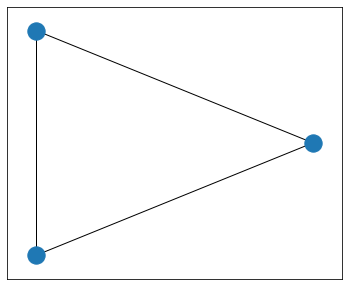

In [6]:
SK_Model_Graph = SK_Model.graph
fig, ax = plt.subplots(figsize=(6,5))
pos = nx.circular_layout(SK_Model_Graph)
nx.draw_networkx(SK_Model_Graph, pos=pos, with_labels=False)
# fig.tight_layout()
#ax.axis('off')

In [7]:
SK_Model_qp = SK_Model.to_quadratic_program()

In [8]:
print(SK_Model_qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: SK-model

Minimize
 obj: 2.309401076759 x0 + [ - 4.618802153517 x0*x1 - 4.618802153517 x0*x2
      + 4.618802153517 x1*x2 ]/2 -0.577350269190
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



In [9]:
SK_Model_Ising = SK_Model_qp.to_ising()
SK_Model_Hamiltonian = SK_Model_Ising[0].to_matrix()

In [10]:
#Creates the grid visualization of the density matrices

def create_density_plot(data):

    array = np.array(data)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

In [11]:
# Initializes values

beta = 1 #Note that B = 1/T
qubit = 3

# Creates the target density matrix

def create_target(qubit, beta, hamiltonian):

    h = hamiltonian
    y = -1*float(beta)*h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1/norm)*new_matrix

    # Calculates the entropy, the expectation value, and the final cost

    entropy = -1*np.trace(np.matmul(final_target, scipy.linalg.logm(final_target)))
    ev = np.trace(np.matmul(final_target, h))
    real_cost = beta*np.trace(np.matmul(final_target, h)) - entropy

    # Plots the final density matrix

    create_density_plot(final_target.real)

    # Prints the calculated values

    print("Expectation Value: "+str(ev))
    print("Entropy: "+str(entropy))
    print("Final Cost: "+str(real_cost))

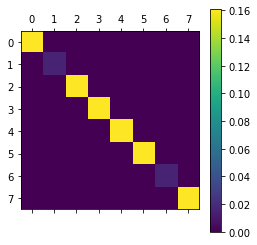

Expectation Value: (-0.5033432861349194+0j)
Entropy: (1.898337128267965-0j)
Final Cost: (-2.4016804144028843+0j)


In [12]:
create_target(qubit, beta, SK_Model_Hamiltonian)

In [13]:
#Creates the RYY gate using the RXX gate and single-qubit rotations

def ryy_gate(circ, qubit1, qubit2, theta):

    circ.s(qubit1)
    circ.s(qubit2)
    circ.rxx(theta, qubit1, qubit2)
    circ.sdg(qubit1)
    circ.sdg(qubit2)

In [14]:
# Creates the single rotational ansatz

def single_rotation(circ, phi_params, qubit):

    circ.rz(phi_params[0], qubit)
    circ.ry(phi_params[1], qubit)
    circ.rx(phi_params[2], qubit)

In [15]:
#Creates the double rotational unitary

def double_rotation(circ, phi_params, qubit1, qubit2):

    circ.rzz(phi_params[0], qubit1, qubit2)
    circ.rxx(phi_params[1], qubit1, qubit2)
    ryy_gate(circ, qubit1, qubit2, phi_params[2])

In [16]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError

from qiskit.providers.aer.noise import depolarizing_error

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit unitary gate
error = depolarizing_error(0.1, 1)
noise_model.add_all_qubit_quantum_error(error, ['add_u_gate'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['add_u_gate']
  All-qubits errors: ['add_u_gate']


In [17]:
double_pair = [[[0, 1], [1, 2]]]
depth = 1
#Creates the ansatz unitary

def add_u_gate(circ, double_phi, single_phi, qubit):
    for j in range(0, depth):

        for i in range(0, qubit-1):
            double_rotation(circ, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])

        for i in range(0, qubit):
            single_rotation(circ, single_phi[j][i], i)

        for i in range(0, qubit-1):
            double_rotation(circ, double_phi[j][i], double_pair[j][i][0], double_pair[j][i][1])
        



In [18]:
# Creates the probability distribution according to the theta parameters

def create_dist(theta_param):

    prob = []
    for i in range(0, len(theta_param)):
        prob.append([math.exp(-1*theta_param[i]), 1-math.exp(-1*theta_param[i])])

    return prob

In [19]:
#Creates the initialization unitary for each of the computational basis states

def create_v_gate(circ, prep_state):

    for i in range(0, len(prep_state)):
        if (prep_state[i] == 1):
            circ.x(i)

Cost at Step 0: -1.4294116488123496
Cost at Step 50: -2.1525630653075942
Cost at Step 100: -2.274545298831421
Cost at Step 150: -2.286770477334675
Cost at Step 200: -2.287673512951142
Cost at Step 250: -2.2877695994393115
Cost at Step 300: -2.2877821750351557
Cost at Step 350: -2.287785029517753
Cost at Step 400: -2.28778524492515
Cost at Step 450: -2.2877852775084175
     fun: -2.2877852761295556
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 452
  status: 1
 success: True
       x: array([ 1.57080752e+00,  3.14162108e+00,  1.57080700e+00,  1.57082410e+00,
       -5.04784903e-05,  1.57082928e+00,  2.79627096e+00, -1.57070475e+00,
        1.22547765e+00, -1.63043472e+00,  1.57094414e+00,  1.63041129e+00,
       -1.55460121e+00, -1.57054803e+00,  1.62134211e-02,  1.13278280e+00,
        6.93140452e-01,  3.88843482e-01])


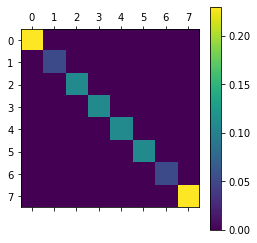

Final Entropy: 1.950102534136878
Final Expectation Value: -0.33768274199267745
Final Cost: -2.2877852761295556


In [20]:
counting_num = 0

def cost_function(param):
    
    global counting_num

    ham_matrix = SK_Model_Hamiltonian

    double_phi = [[param[0:3], param[3:6]]]
    single_phi = [[param[6:9], param[9:12], param[12:15]]]
    theta = param[15:18]

    opt_prob_dist = create_dist(theta)

    p = []
    for i in range(0, 2):
        for j in range(0, 2):
            for v in range(0, 2):
                p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

    state = np.zeros((2**qubit, 2**qubit))

    for l in range(0, 2**qubit):

        circ = QuantumCircuit(qubit)

        create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
        add_u_gate(circ, double_phi, single_phi, qubit)
        
        backend = Aer.get_backend('statevector_simulator')
        job = execute(circ, backend)
        result = job.result()
        outputstate = result.get_statevector(circ)

        state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

    entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))

    cost = beta*np.trace(np.matmul(ham_matrix, state)) - entropy
    if (counting_num%50 == 0):
        print("Cost at Step "+str(counting_num)+": "+str(cost.real))
    counting_num += 1
    return cost.real

#Creates lits of random numbers as the initial parameters fed into the circuit

init1 = [random.randint(100, 200)/100 for i in range(0, qubit)]
init2 = [random.randint(-100, 100)/50 for i in range(0, 5*qubit)]
init = init2+init1

#Creates the optimization process

out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':1000})
g = out['x']
print(out)

param = g

# Prepares the learned state

double_phi = [[param[0:3], param[3:6]]]
single_phi = [[param[6:9], param[9:12], param[12:15]]]
theta = param[15:18]

opt_prob_dist = create_dist(theta)

p = []
for i in range(0, 2):
    for j in range(0, 2):
        for v in range(0, 2):
            p.append(opt_prob_dist[0][i]*opt_prob_dist[1][j]*opt_prob_dist[2][v])

state = np.zeros((2**qubit, 2**qubit))

for l in range(0, 2**qubit):

    circ = QuantumCircuit(qubit, qubit)
    create_v_gate(circ, [int(i) for i in list(bin(l)[2:].zfill(qubit))])
    add_u_gate(circ, double_phi, single_phi, qubit)

    backend = Aer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ)

    state = np.add(state, p[l]*np.outer(outputstate, np.conj(outputstate)))

ham_matrix = SK_Model_Hamiltonian
entropy = -1*np.trace(np.matmul(state, scipy.linalg.logm(state)))
ev = np.trace(np.matmul(ham_matrix, state))

create_density_plot(state.real)

print("Final Entropy: "+str(entropy.real))
print("Final Expectation Value: "+str(ev.real))
print("Final Cost: "+str(beta*ev.real - entropy.real))